# Model and Training

## Load the model

In [1]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
ON_COLAB = False  # Set to True if running on Google Colab
if ON_COLAB:
    !pip install dotenv
    
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


# Configuration
target_size_for_training = (128, 128)
data_root = f"./raw_data"  # root directory containing 'train' and 'test' subfolders
if ON_COLAB:
    from google.colab import drive

    drive.mount(os.getenv("GOOGLE_DRIVE_CONTENT_PATH", "/content/drive"))
    data_root = os.getenv("GOOGLE_DRIVE_PATH_RESIZED", data_root)

train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")
model_save_dir = os.getenv("MODEL_SAVE_DIR", "./checkpoints")
os.makedirs(model_save_dir, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
IMAGE_SIZE = target_size_for_training[0]

# 2. Define the UNet diffusion model
from model import get_unet_model

model = get_unet_model(
    sample_size=IMAGE_SIZE,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    dropout=0.1,
).to(DEVICE)

# Print model summary
def print_model_summary(model):
    print("Model Summary:")
    print(f"Model Type: {type(model).__name__}")
    print(f"Number of Parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Device: {next(model.parameters()).device}")

print_model_summary(model)


# 5. Load the model checkpoint if available
def load_checkpoint(ckpt_path, model, optimizer=None, device=torch.device("cpu")):
    loaded = False
    if not os.path.exists(ckpt_path):
        print(f"No checkpoint found at {ckpt_path}, starting fresh.")
        return loaded, model, optimizer, 0

    checkpoint = torch.load(ckpt_path, map_location=device)
    
    # Rimuovi il prefisso "_orig_mod." dalle chiavi se presente
    new_state_dict = {}
    for k, v in checkpoint["model"].items():
        if k.startswith("_orig_mod."):
            new_k = k.replace("_orig_mod.", "")
            new_state_dict[new_k] = v
        else:
            new_state_dict[k] = v
    
    model.load_state_dict(new_state_dict)
    model.to(device)
    loaded = True
    start_epoch = checkpoint.get("epoch", 0)
    
    if optimizer is not None and "optimizer" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer"])
        print(f"Loaded optimizer state from checkpoint '{ckpt_path}'")
    else:
        print("Optimizer state not found in checkpoint, starting with a new optimizer.")
    
    print(f"Loaded checkpoint '{ckpt_path}' (epoch {start_epoch})")
    return loaded, model, optimizer, start_epoch


WEIGHT_DECAY = 1e-5  # weight decay for regularization
optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Load the model checkpoint
ckpt = "checkpoints/ddim_unet_epoch20.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    ckpt, model, optimizer, device=DEVICE
)
model.eval()
if isModelLoadedFromCheckpoint:
    print(f"Model {ckpt.split('/')[-1]} loaded and moved to {DEVICE}, starting from epoch {start_epoch}.")
else:
    print(f"Model {ckpt.split('/')[-1]} not found. Starting from scratch, loaded on {DEVICE}, starting from epoch {start_epoch}.")

train_losses, val_losses = [], []

/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Summary:
Model Type: UNet2DModel
Number of Parameters: 15722625
Device: cuda:0
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch20.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch20.pth' (epoch 20)
Model ddim_unet_epoch20.pth loaded and moved to cuda, starting from epoch 20.


## Training and validation

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from matplotlib import pyplot as plt
from utils import NUM_TRAIN_TIMESTEPS, sample_images, AugmentedDataset, save_checkpoint

# Config
BATCH_SIZE = 16
NUM_EPOCHS = 20
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg")


# Dataset Preparation
def count_images(root_dir, extensions=IMAGE_EXTENSIONS):
    return sum(
        fname.lower().endswith(extensions)
        for _, _, filenames in os.walk(root_dir)
        for fname in filenames
    )


print(f"Training images before augmentation: {count_images(train_dir)}")
print(f"Validation images before augmentation: {count_images(test_dir)}")

train_dataset = AugmentedDataset(root_dir=train_dir, image_size=IMAGE_SIZE)
test_dataset = AugmentedDataset(root_dir=test_dir, image_size=IMAGE_SIZE)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(test_loader.dataset)}")

# Scheduler and Model Setup
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)
ddim_scheduler = DDIMScheduler(
    beta_start=noise_scheduler.config.beta_start,
    beta_end=noise_scheduler.config.beta_end,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample=True,
)
ddim_scheduler.set_timesteps(NUM_TRAIN_TIMESTEPS)

model = torch.compile(model)
scaler = GradScaler(device=DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Training Loop
train_losses, val_losses = [], []

print(
    f"Training on {DEVICE} | Batch Size: {BATCH_SIZE} | Epochs: {NUM_EPOCHS} | Starting at epoch {start_epoch}"
)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_train_loss = 0.0

    for step, (images, _) in enumerate(train_loader, 1):
        images = images.to(DEVICE)
        noise = torch.randn_like(images)
        timesteps = torch.randint(
            0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
        )

        optimizer.zero_grad()
        with autocast(device_type=DEVICE.type, enabled=True):
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_train_loss += loss.item()

        if step % 50 == 0 or step == len(train_loader):
            print(
                f"[Epoch {epoch}/{NUM_EPOCHS} | Step {step}/{len(train_loader)}] Train Loss: {loss.item():.6f}"
            )

        # if step % (len(train_loader) // 3) == 0:
        #     print(f"Reached step {step} of epoch {epoch}. Saving sample image and weights.")
        #     sample_images(
        #         output_path=f"{model_save_dir}/epoch_{epoch + start_epoch}_step_{step}.png",
        #         num_steps=NUM_TRAIN_TIMESTEPS,
        #         DEVICE=DEVICE,
        #         IMAGE_SIZE=IMAGE_SIZE,
        #         model=model,
        #         ddim_scheduler=ddim_scheduler,
        #     )
        #     ckpt_path = os.path.join(
        #         model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}_step{step}.pth"
        #     )
        #     save_checkpoint(
        #         model=model,
        #         optimizer=optimizer,
        #         epoch=epoch + start_epoch,
        #         path=ckpt_path,
        #     )

    sample_images(
        output_path=f"{model_save_dir}/epoch_{epoch + start_epoch}.png",
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
    )

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} complete. Avg Train Loss: {avg_train_loss:.6f}")

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            noise = torch.randn_like(images)
            timesteps = torch.randint(
                0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
            )

            with autocast(device_type=DEVICE.type, enabled=True):
                noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
                noise_pred = model(noisy_images, timesteps).sample
                total_val_loss += F.mse_loss(noise_pred, noise).item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch} complete. Avg Validation Loss: {avg_val_loss:.6f}")

    ckpt_path = os.path.join(
        model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}.pth"
    )
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + start_epoch,
        path=ckpt_path,
    )

Training images before augmentation: 3306
Validation images before augmentation: 327
Training samples: 13224
Validation samples: 1308
Training on cuda | Batch Size: 16 | Epochs: 20 | Starting at epoch 20


W0514 18:01:22.155000 5825 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


[Epoch 1/20 | Step 50/827] Train Loss: 0.003319
[Epoch 1/20 | Step 100/827] Train Loss: 0.007456
[Epoch 1/20 | Step 150/827] Train Loss: 0.020998
[Epoch 1/20 | Step 200/827] Train Loss: 0.015018
[Epoch 1/20 | Step 250/827] Train Loss: 0.011233
[Epoch 1/20 | Step 300/827] Train Loss: 0.010936
[Epoch 1/20 | Step 350/827] Train Loss: 0.009657
[Epoch 1/20 | Step 400/827] Train Loss: 0.002667
[Epoch 1/20 | Step 450/827] Train Loss: 0.007183
[Epoch 1/20 | Step 500/827] Train Loss: 0.017635
[Epoch 1/20 | Step 550/827] Train Loss: 0.004476
[Epoch 1/20 | Step 600/827] Train Loss: 0.004738
[Epoch 1/20 | Step 650/827] Train Loss: 0.004791
[Epoch 1/20 | Step 700/827] Train Loss: 0.002149
[Epoch 1/20 | Step 750/827] Train Loss: 0.006342
[Epoch 1/20 | Step 800/827] Train Loss: 0.009252
[Epoch 1/20 | Step 827/827] Train Loss: 0.005874


Sampling DDIM:   0%|          | 0/1000 [00:00<?, ?it/s]/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
Sampling DDIM: 100%|██████████| 1000/1000 [00:41<00:00, 24.07it/s]

Sample saved to ./checkpoints/epoch_21.png
Epoch 1 complete. Avg Train Loss: 0.009116


Epoch 1 complete. Avg Validation Loss: 0.009299
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch21.pth
[Epoch 2/20 | Step 50/827] Train Loss: 0.007645
[Epoch 2/20 | Step 100/827] Train Loss: 0.007604
[Epoch 2/20 | Step 150/827] Train Loss: 0.011446
[Epoch 2/20 | Step 200/827] Train Loss: 0.009895
[Epoch 2/20 | Step 250/827] Train Loss: 0.018209
[Epoch 2/20 | Step 300/827] Train Loss: 0.007563
[Epoch 2/20 | Step 350/827] Train Loss: 0.011225
[Epoch 2/20 | Step 400/827] Train Loss: 0.002435
[Epoch 2/20 | Step 450/827] Train Loss: 0.003005
[Epoch 2/20 | Step 500/827] Train Loss: 0.003537
[Epoch 2/20 | Step 550/827] Train Loss: 0.006033
[Epoch 2/20 | Step 600/827] Train Loss: 0.001758


KeyboardInterrupt: 

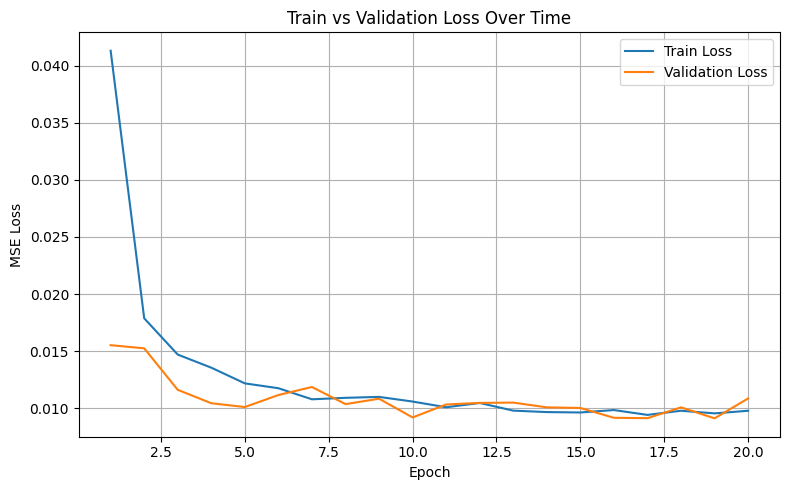

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to the loss history file
history_file = os.path.join(model_save_dir, "loss_history.txt")

# Load existing history if it exists
all_train_losses = []
all_val_losses = []

if os.path.exists(history_file):
    with open(history_file, "r") as f:
        lines = f.readlines()[1:]  # Skip header
        for line in lines:
            _, train_loss, val_loss = line.strip().split("\t")
            all_train_losses.append(float(train_loss))
            all_val_losses.append(float(val_loss))

# Append current session's losses
all_train_losses.extend(train_losses)
all_val_losses.extend(val_losses)

# Save updated history
with open(history_file, "w") as f:
    f.write("Epoch\tTrain Loss\tValidation Loss\n")
    for i, (tr, vl) in enumerate(zip(all_train_losses, all_val_losses), 1):
        f.write(f"{i}\t{tr:.6f}\t{vl:.6f}\n")

# Plot full loss history
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, label="Train Loss")
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from diffusers import DDPMScheduler, DDIMScheduler
from tqdm import tqdm
from utils import sample_images

# Imposta il numero di step di inferenza per DDIM (uguale a NUM_TRAIN_TIMESTEPS di default)
# 6. Sampling example with DDIM
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)

ddim_scheduler = DDIMScheduler(
    beta_start=noise_scheduler.config.beta_start,
    beta_end=noise_scheduler.config.beta_end,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample=True,
)

ddim_scheduler.set_timesteps(NUM_TRAIN_TIMESTEPS)


# Sample images
for i in range(10):
    sample_images(
        output_path=f"result/ddim_sample_epoch{epoch + start_epoch}_{i}.png",
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
    )

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.48it/s]


Sample saved to result/ddim_sample_epoch20_0.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.61it/s]


Sample saved to result/ddim_sample_epoch20_1.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.96it/s]


Sample saved to result/ddim_sample_epoch20_2.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.74it/s]


Sample saved to result/ddim_sample_epoch20_3.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.65it/s]


Sample saved to result/ddim_sample_epoch20_4.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.62it/s]


Sample saved to result/ddim_sample_epoch20_5.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.54it/s]


Sample saved to result/ddim_sample_epoch20_6.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.66it/s]


Sample saved to result/ddim_sample_epoch20_7.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.78it/s]


Sample saved to result/ddim_sample_epoch20_8.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.95it/s]

Sample saved to result/ddim_sample_epoch20_9.png
